In [1]:
import sys
import pwreg as pw

import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/ply/anaconda3/envs/ants/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
project_path = "/mnt/d/Code/repos/UGPy"

In [3]:
fixed = pw.Image([0.658, 0.23, 0.23],
                 filename = f'{project_path}/data/changes/learners/1-23C4/prob_map/crops/map_id_rzn02jyz_ckpt_3m51q4ne_1-23E2_left_main.tif') # tp 1

moving = pw.Image([0.658, 0.23, 0.23], 
                  filename = f'{project_path}/data/changes/learners/1-23C4/prob_map/crops/map_id_74tmf0l2_ckpt_3m51q4ne_1-23E4_left_main.tif') # tp 2

warped = pw.Image([0.658, 0.23, 0.23], 
                  filename = f'{project_path}/data/changes/learners/1-23C4/registered/crops/map_id_74tmf0l2_ckpt_3m51q4ne_1-23E4_to_1-23E2_left_main.tif') # tp 2

print(f'shape\nFixed {fixed.shape},\nMoving {moving.shape},\nWarped {warped.shape}')

shape
Fixed (121, 799, 420),
Moving (131, 799, 420),
Warped (121, 799, 420)


In [4]:
# flatten and turn to % 
a = fixed.img.flatten()/10
b = moving.img.flatten()/10
c = warped.img.flatten()/10

In [5]:
min_value = 5
a5 = a[a>min_value]
b5 = b[b>min_value]
c5 = c[c>min_value]

print(f"max : {np.min(a5)},{np.min(b5)},{np.min(c5)}")
print(f"max : {np.max(a5)},{np.max(b5)},{np.max(c5)}")

max : 5.1,5.1,5.1
max : 99.1,98.3,98.3


In [6]:
min_value = 1
a1 = a[a>min_value]
b1 = b[b>min_value]
c1 = c[c>min_value]

print(f"max : {np.min(a1)},{np.min(b1)},{np.min(c1)}")
print(f"max : {np.max(a1)},{np.max(b1)},{np.max(c1)}")

max : 1.1,1.1,1.1
max : 99.1,98.3,98.3


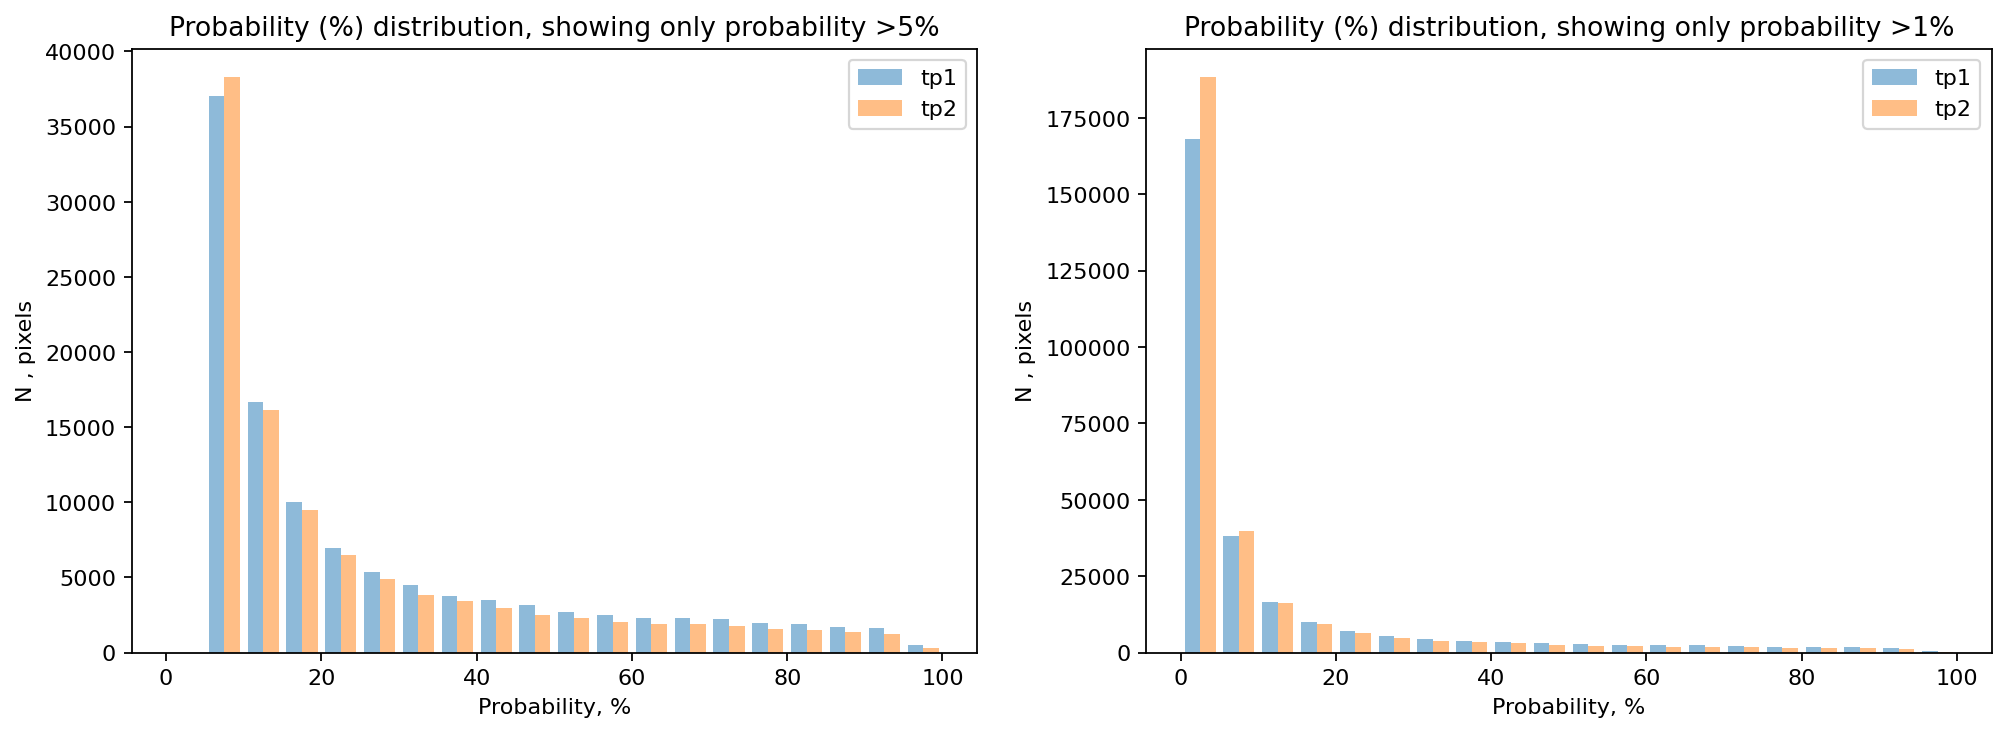

In [19]:
# histogram
common_params = dict(bins=20, 
                     range=(0, 100),
                    alpha = 0.5)

plt.figure(figsize = (15,5), dpi = 160)
plt.subplot(121)
plt.title('Probability (%) distribution, showing only probability >5%')
plt.hist((a5, b5), **common_params)
plt.xlabel("Probability, %")
plt.ylabel("N , pixels")
plt.legend(["tp1", "tp2"])

plt.subplot(122)
plt.title('Probability (%) distribution, showing only probability >1%')
(n, bins, patches) = plt.hist((a1, b1), **common_params)
plt.legend(["tp1", "tp2"])
plt.xlabel("Probability, %")
plt.ylabel("N , pixels")
plt.show()

In [8]:
(n[1]-n[0])/n[0]

array([0.1, 0.0, -0.0, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.3])

In [15]:
# making voxel image 

z, y, x = fixed.shape
voxel_side = 30
print(fixed.shape)

(121, 799, 420)


In [16]:
nz = np.ceil(z/voxel_side)
ny = np.ceil(y/voxel_side)
nx = np.ceil(x/voxel_side)

prob1_img = np.zeros(fixed.shape)
prob2_img = np.zeros(fixed.shape)
change_img = np.zeros(fixed.shape)

for iz in np.arange(nz):
    from_z = int(iz*voxel_side)
    to_z = int(min(z, (iz + 1)*voxel_side))
    
    for iy in np.arange(ny):
        from_y = int(iy*voxel_side)
        to_y = int(min(y, (iy + 1)*voxel_side))
    
        for ix in np.arange(nx):
            from_x = int(ix*voxel_side)
            to_x = int(min(x, (ix + 1)*voxel_side))
            
            prob1 = np.sum(fixed.img[from_z:to_z,from_y:to_y,from_x:to_x])/(voxel_side**3)
            prob2 = np.sum(warped.img[from_z:to_z,from_y:to_y,from_x:to_x])/(voxel_side**3)
            
            prob1_img[from_z:to_z,from_y:to_y,from_x:to_x] = prob1
            prob2_img[from_z:to_z,from_y:to_y,from_x:to_x] = prob2
            
            ratio = prob2-prob1
            change_img[from_z:to_z,from_y:to_y,from_x:to_x] = ratio
            
print(np.max(change_img.flatten()))
print(np.min(change_img.flatten())) 

prob1_img = pw.Image([0.658, 0.23, 0.23], img = prob1_img)
prob2_img = pw.Image([0.658, 0.23, 0.23], img = prob2_img)

prob1_img.imwrite( f'{project_path}/data/changes/learners/1-23C4/prob_map/changes/crops/PROB1_map_ckpt_3m51q4ne_id_rzn02jyz_1-23E2_left_main.tif')
prob2_img.imwrite( f'{project_path}/data/changes/learners/1-23C4/prob_map/changes/crops/PROB2_map_ckpt_3m51q4ne_id_74tmf0l2_1-23E4_4to2_left_main.tif')

11.185296296296295
-7.508111111111111


In [17]:
import copy

change_img_pos = copy.deepcopy(np.round(change_img)*100).astype(np.int16)
change_img_neg = copy.deepcopy(np.round(change_img)*100).astype(np.int16)

print(np.max(change_img_pos.flatten()))
print(np.min(change_img_pos.flatten()))   

change_img_pos[change_img_pos<0] = 0
change_img_neg[change_img_neg>0] = 0
change_img_neg = -change_img_neg

print(np.max(change_img_pos.flatten()))
print(np.min(change_img_pos.flatten())) 

print(np.max(change_img_neg.flatten()))
print(np.min(change_img_neg.flatten())) 

change_pos = pw.Image([0.658, 0.23, 0.23], img = change_img_pos)
change_neg = pw.Image([0.658, 0.23, 0.23], img = change_img_neg)
change_pos.imwrite( f'{project_path}/data/changes/learners/1-23C4/prob_map/changes/crops/changePOS_map_ckpt_3m51q4ne_id_rzn02jyz_1-23E2_id_74tmf0l2_1-23E4_4to2_left_main.tif')
change_neg.imwrite( f'{project_path}/data/changes/learners/1-23C4/prob_map/changes/crops/changeNEG_map_ckpt_3m51q4ne_id_rzn02jyz_1-23E2_id_74tmf0l2_1-23E4_4to2_left_main.tif')

1100
-800
1100
0
800
0
